In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [9]:
data_json = '''
[
    {"YearMonth": "2021-06", "Rainfall (mm)": 1.76, "Sunshine (hours)": 3.8, "Speed of maximum wind gust (km/h)": 35.9, "Sentiment": 0.064374},
    {"YearMonth": "2021-07", "Rainfall (mm)": 0.664516, "Sunshine (hours)": 4.958, "Speed of maximum wind gust (km/h)": 34.774, "Sentiment": 0.843468},
    {"YearMonth": "2021-08", "Rainfall (mm)": 0.722581, "Sunshine (hours)": 5.003, "Speed of maximum wind gust (km/h)": 33.467, "Sentiment": 0.052984},
    {"YearMonth": "2021-09", "Rainfall (mm)": 0.36, "Sunshine (hours)": 7.577, "Speed of maximum wind gust (km/h)": 37.233, "Sentiment": 0.852877},
    {"YearMonth": "2021-10", "Rainfall (mm)": 2.451613, "Sunshine (hours)": 6.477, "Speed of maximum wind gust (km/h)": 38.677, "Sentiment": 0.040025},
    {"YearMonth": "2021-11", "Rainfall (mm)": 1.413333, "Sunshine (hours)": 6.413, "Speed of maximum wind gust (km/h)": 35.267, "Sentiment": 0.847334},
    {"YearMonth": "2021-12", "Rainfall (mm)": 2.303226, "Sunshine (hours)": 6.687, "Speed of maximum wind gust (km/h)": 36.548, "Sentiment": 0.053864},
    {"YearMonth": "2022-01", "Rainfall (mm)": 3.509677, "Sunshine (hours)": 7.510, "Speed of maximum wind gust (km/h)": 36.8, "Sentiment": 0.122418},
    {"YearMonth": "2022-02", "Rainfall (mm)": 0.221429, "Sunshine (hours)": 9.246, "Speed of maximum wind gust (km/h)": 38.296, "Sentiment": 0.069371},
    {"YearMonth": "2022-03", "Rainfall (mm)": 0.090323, "Sunshine (hours)": 8.526, "Speed of maximum wind gust (km/h)": 33.581, "Sentiment": 0.857223},
    {"YearMonth": "2022-04", "Rainfall (mm)": 4.421429, "Sunshine (hours)": 4.641, "Speed of maximum wind gust (km/h)": 27.704, "Sentiment": 0.068838}
]
'''

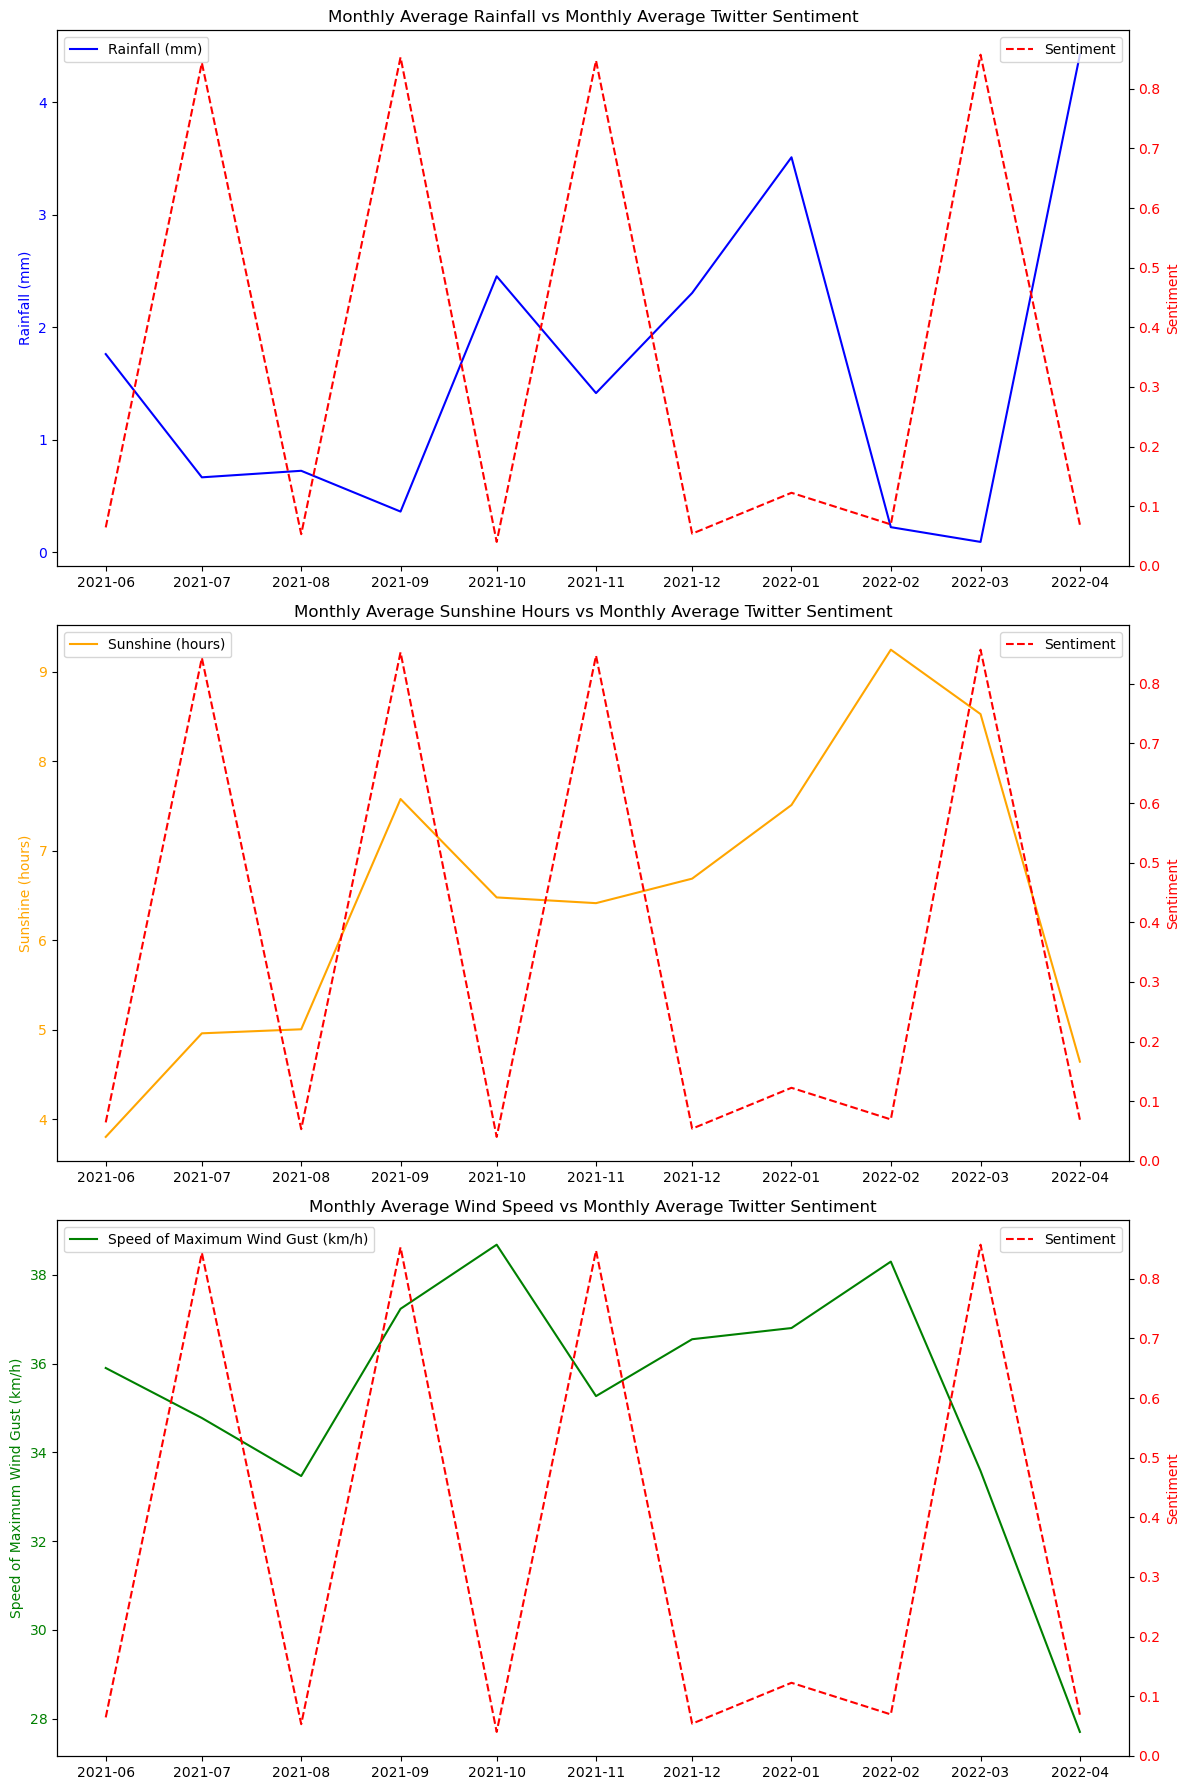

In [10]:
# Load data into a DataFrame
data_df = pd.read_json(data_json)
data_df['YearMonth'] = pd.to_datetime(data_df['YearMonth'])

# Plotting the data with dual y-axes
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Function to create dual-axis line plots
def plot_dual_axis(ax, x, y1, y2, color1, color2, label1, label2, title):
    ax.plot(x, y1, color=color1, label=label1)
    ax.set_ylabel(label1, color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    ax.set_title(title)
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=color2, linestyle='--', label=label2)
    ax2.set_ylabel(label2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')

# Rainfall and Sentiment
plot_dual_axis(axs[0], data_df['YearMonth'], data_df['Rainfall (mm)'], data_df['Sentiment'],
               'blue', 'red', 'Rainfall (mm)', 'Sentiment',
               'Monthly Average Rainfall vs Monthly Average Twitter Sentiment')

# Sunshine and Sentiment
plot_dual_axis(axs[1], data_df['YearMonth'], data_df['Sunshine (hours)'], data_df['Sentiment'],
               'orange', 'red', 'Sunshine (hours)', 'Sentiment',
               'Monthly Average Sunshine Hours vs Monthly Average Twitter Sentiment')

# Wind Speed and Sentiment
plot_dual_axis(axs[2], data_df['YearMonth'], data_df['Speed of maximum wind gust (km/h)'], data_df['Sentiment'],
               'green', 'red', 'Speed of Maximum Wind Gust (km/h)', 'Sentiment',
               'Monthly Average Wind Speed vs Monthly Average Twitter Sentiment')

plt.tight_layout()
plt.show()